In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import randint, norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR

In [5]:
df = pd.read_csv('./data/medical-costs.csv')
df

,id,age,sex,bmi,children,smoker,region,charges
0,0,19.0,female,27.900,0,yes,southwest,16884.92400
1,1,18.0,male,33.770,1,no,southeast,1725.55230
2,2,28.0,male,33.000,3,no,southeast,4449.46200
3,3,33.0,male,22.705,0,no,northwest,21984.47061
4,4,32.0,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...,...
1333,1333,50.0,male,30.970,3,no,northwest,10600.54830
1334,1334,18.0,female,31.920,0,no,northeast,2205.98080
1335,1335,18.0,female,36.850,0,no,southeast,1629.83350
1336,1336,21.0,female,25.800,0,no,southwest,2007.94500


In [6]:
df = df.drop(columns='id')

<AxesSubplot:xlabel='charges', ylabel='Density'>

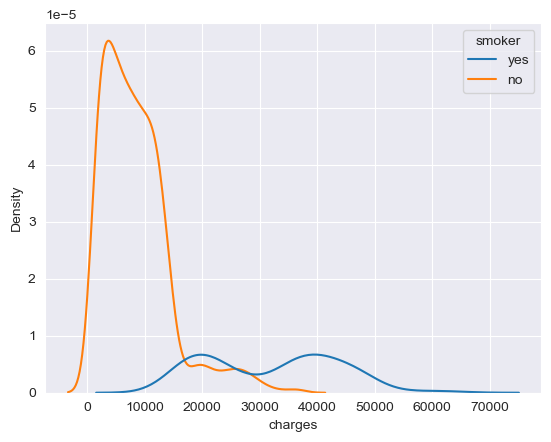

In [7]:
sns.kdeplot(data=df, x='charges', hue='smoker')

In [72]:
df.isna().sum()

age         64
sex          0
bmi          0
children     0
smoker       0
region       0
charges      0
dtype: int64

In [8]:
imputer = SimpleImputer(strategy='mean')
df.age = imputer.fit_transform(df[['age']])

In [9]:
df.sex = df.sex.replace({'male': 0, 'female': 1})

In [10]:
df['male'] = df.sex.replace({'male': 1, 'female': 0})
df.smoker = df.smoker.replace({'yes': 1, 'no': 0})
df = df.drop(columns='sex')
df

,age,bmi,children,smoker,region,charges,male
0,19.0,27.900,0,1,southwest,16884.92400,1
1,18.0,33.770,1,0,southeast,1725.55230,0
2,28.0,33.000,3,0,southeast,4449.46200,0
3,33.0,22.705,0,0,northwest,21984.47061,0
4,32.0,28.880,0,0,northwest,3866.85520,0
...,...,...,...,...,...,...,...
1333,50.0,30.970,3,0,northwest,10600.54830,0
1334,18.0,31.920,0,0,northeast,2205.98080,1
1335,18.0,36.850,0,0,southeast,1629.83350,1
1336,21.0,25.800,0,0,southwest,2007.94500,1


In [11]:
df = pd.get_dummies(data=df, columns=['region'])
df

,age,bmi,children,smoker,charges,male,region_northeast,region_northwest,region_southeast,region_southwest
0,19.0,27.900,0,1,16884.92400,1,0,0,0,1
1,18.0,33.770,1,0,1725.55230,0,0,0,1,0
2,28.0,33.000,3,0,4449.46200,0,0,0,1,0
3,33.0,22.705,0,0,21984.47061,0,0,1,0,0
4,32.0,28.880,0,0,3866.85520,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50.0,30.970,3,0,10600.54830,0,0,1,0,0
1334,18.0,31.920,0,0,2205.98080,1,1,0,0,0
1335,18.0,36.850,0,0,1629.83350,1,0,0,1,0
1336,21.0,25.800,0,0,2007.94500,1,0,0,0,1


In [12]:
X = df.drop(columns='charges')
y = df.charges
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
def calc_error(model, X_test, y_true):
    predictions = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_true, predictions))

In [82]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
calc_error(lin_reg, X_test, y_test)

5872.896810106856

In [84]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train)
calc_error(forest, X_test, y_test)

4774.824864556555

In [91]:
svm = SVR()
svm.fit(X_train, y_train)
calc_error(svm, X_test, y_test)

12896.308641900068

### RandomForest erscheint am vielversprechendsten

# Hyperparameter tuning

*Hyperparameter* - werden von Menschen gesetzt, **nicht** vom model gelernt; vor allem Konstruktorparameter


![flow](./assets/grid_search_workflow.png)

<AxesSubplot:>

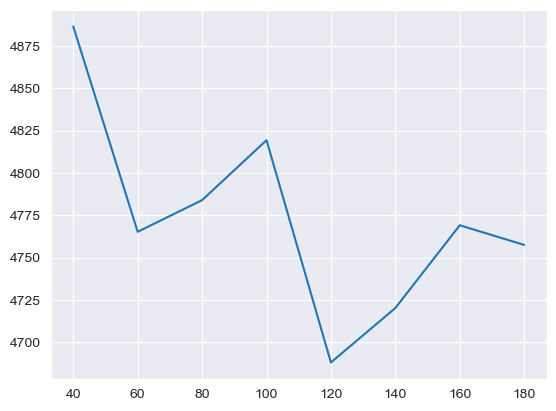

In [34]:
errors = {}
for n in range(40, 200, 20):
    forest = RandomForestRegressor(n_estimators=n)
    forest.fit(X_train, y_train)
    errors[n] = calc_error(forest, X_test, y_test)

sns.lineplot(data=errors, x=errors.keys(), y=errors.values())

### Testset soll unbekannte Daten simulieren ==> nicht zum Trainieren verwenden

![cv](./assets/grid_search_cross_validation.png)

In [40]:
params = {'n_estimators': range(50, 300, 50),
          'max_features': [1.0, 'sqrt', 'log2']}
grid = GridSearchCV(estimator=RandomForestRegressor(),
                    param_grid=params,
                    scoring='neg_mean_squared_error',  # -mse, damit höher=besser
                    cv=5,
                    n_jobs=4)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_features': [1.0, 'sqrt', 'log2'],
                         'n_estimators': range(50, 300, 50)},
             scoring='neg_mean_squared_error')

In [23]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.087501,0.012499,0.003126,0.006252,1.0,50,"{'max_features': 1.0, 'n_estimators': 50}",-2.662470e+07,-1.679176e+07,-2.602017e+07,-3.306083e+07,-2.581854e+07,-2.566320e+07,5.186587e+06,15
1,0.181252,0.012501,0.006250,0.007655,1.0,100,"{'max_features': 1.0, 'n_estimators': 100}",-2.632164e+07,-1.657193e+07,-2.608799e+07,-3.253627e+07,-2.458098e+07,-2.521976e+07,5.112578e+06,14
2,0.290624,0.007656,0.015624,0.000002,1.0,150,"{'max_features': 1.0, 'n_estimators': 150}",-2.568648e+07,-1.644528e+07,-2.594899e+07,-3.265836e+07,-2.505541e+07,-2.515890e+07,5.159117e+06,13
3,0.403442,0.024892,0.018749,0.006250,1.0,200,"{'max_features': 1.0, 'n_estimators': 200}",-2.573681e+07,-1.625427e+07,-2.583528e+07,-3.275090e+07,-2.495108e+07,-2.510567e+07,5.248837e+06,12
4,0.534426,0.023361,0.024698,0.002345,1.0,250,"{'max_features': 1.0, 'n_estimators': 250}",-2.598590e+07,-1.613094e+07,-2.527332e+07,-3.256315e+07,-2.513386e+07,-2.501744e+07,5.233061e+06,11
5,0.073207,0.003006,0.004846,0.001178,sqrt,50,"{'max_features': 'sqrt', 'n_estimators': 50}",-2.495640e+07,-1.677021e+07,-2.601170e+07,-3.156609e+07,-2.475524e+07,-2.481193e+07,4.727609e+06,10
6,0.139083,0.009838,0.008877,0.001480,sqrt,100,"{'max_features': 'sqrt', 'n_estimators': 100}",-2.438297e+07,-1.526679e+07,-2.503625e+07,-3.132093e+07,-2.443178e+07,-2.408775e+07,5.123152e+06,1
7,0.217428,0.021324,0.011208,0.004166,sqrt,150,"{'max_features': 'sqrt', 'n_estimators': 150}",-2.455037e+07,-1.588836e+07,-2.466127e+07,-3.127361e+07,-2.500942e+07,-2.427661e+07,4.900626e+06,5
8,0.320709,0.006584,0.012498,0.006249,sqrt,200,"{'max_features': 'sqrt', 'n_estimators': 200}",-2.490665e+07,-1.521154e+07,-2.435105e+07,-3.168226e+07,-2.540194e+07,-2.431069e+07,5.266539e+06,7
9,0.362081,0.011434,0.025001,0.007655,sqrt,250,"{'max_features': 'sqrt', 'n_estimators': 250}",-2.413359e+07,-1.559814e+07,-2.517025e+07,-3.135315e+07,-2.471013e+07,-2.419305e+07,5.027232e+06,2


![grid vs random](./assets/grid_vs_random.png)

In [44]:
grid = RandomizedSearchCV(estimator=RandomForestRegressor(),
                          param_distributions={'n_estimators': randint(0, 1000),
                                               'max_features': norm(loc=0.5, scale=0.15)},
                          scoring='neg_mean_squared_error',  # -mse, damit höher=besser
                          cv=5,
                          n_jobs=4)
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=4,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024688296730>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000246881C5850>},
                   scoring='neg_mean_squared_error')

In [45]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.298160,0.035632,0.081375,0.006193,0.510582,880,"{'max_features': 0.5105822292637437, 'n_estima...",-2.435052e+07,-1.490768e+07,-2.404827e+07,-3.090301e+07,-2.352139e+07,-2.354617e+07,5.092080e+06,4
1,0.705244,0.047712,0.031893,0.000846,0.620171,437,"{'max_features': 0.620170874127487, 'n_estimat...",-2.494858e+07,-1.487364e+07,-2.432695e+07,-3.131124e+07,-2.373904e+07,-2.383989e+07,5.247692e+06,7
2,1.535142,0.029111,0.065624,0.006249,0.579696,918,"{'max_features': 0.5796959018268228, 'n_estima...",-2.476415e+07,-1.477555e+07,-2.434811e+07,-3.121328e+07,-2.355837e+07,-2.373189e+07,5.247145e+06,5
3,0.431252,0.021193,0.024999,0.007654,0.312865,336,"{'max_features': 0.3128652379370863, 'n_estima...",-2.590610e+07,-1.878835e+07,-2.616574e+07,-3.452521e+07,-2.699676e+07,-2.647643e+07,4.991634e+06,10
4,1.540625,0.058128,0.074999,0.006250,0.696277,945,"{'max_features': 0.696277429965884, 'n_estimat...",-2.509101e+07,-1.531373e+07,-2.463849e+07,-3.157154e+07,-2.389344e+07,-2.410164e+07,5.183380e+06,8
5,0.506251,0.023385,0.021876,0.007655,0.73552,303,"{'max_features': 0.7355202492224786, 'n_estima...",-2.508996e+07,-1.569526e+07,-2.475243e+07,-3.160934e+07,-2.385914e+07,-2.420122e+07,5.068378e+06,9
6,1.343827,0.057947,0.075676,0.007984,0.489267,890,"{'max_features': 0.48926715888671196, 'n_estim...",-2.426269e+07,-1.482802e+07,-2.391121e+07,-3.101517e+07,-2.356209e+07,-2.351583e+07,5.146543e+06,2
7,0.525460,0.020089,0.029511,0.003096,0.584091,307,"{'max_features': 0.5840910732991864, 'n_estima...",-2.493179e+07,-1.499025e+07,-2.436654e+07,-3.110243e+07,-2.365744e+07,-2.380969e+07,5.148961e+06,6
8,1.618564,0.085505,0.086297,0.007023,0.500751,990,"{'max_features': 0.5007508476164759, 'n_estima...",-2.448397e+07,-1.469285e+07,-2.402884e+07,-3.105600e+07,-2.344819e+07,-2.354197e+07,5.213459e+06,3
9,0.631250,0.045930,0.031250,0.000002,0.546457,428,"{'max_features': 0.5464566272894188, 'n_estima...",-2.433050e+07,-1.459763e+07,-2.406748e+07,-3.079732e+07,-2.348787e+07,-2.345616e+07,5.167309e+06,1
